In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import cupy as cp
import os

import ipdb
import matplotlib
from tqdm import tqdm

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model import FasterRCNNVGG16
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox
from utils.eval_tool import eval_detection_voc
import time

In [3]:
from __future__ import  absolute_import
import torch as t
from torch import nn
from torchvision.models import vgg16
from model.region_proposal_network import RegionProposalNetwork
from model.faster_rcnn import FasterRCNN
from model.roi_module import RoIPooling2D
from utils import array_tool as at
from utils.config import opt

import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple

In [4]:
def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result

(9, 4)


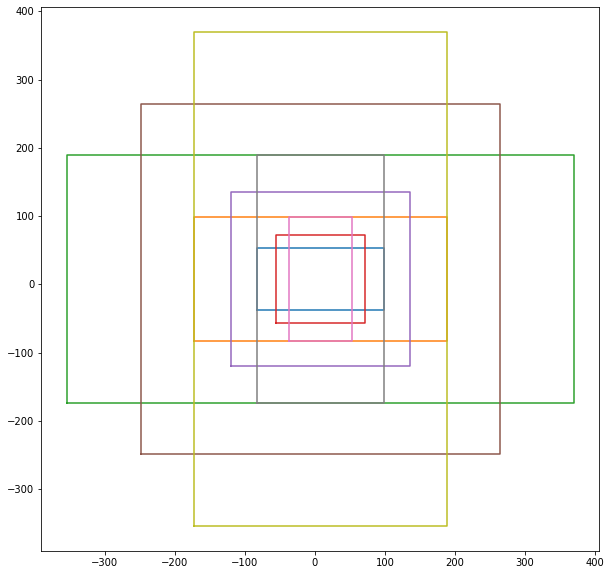

In [5]:
from model.utils.bbox_tools import generate_anchor_base

# (y_{min}, x_{min}, y_{max}, x_{max})
anchor_base = generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32])
print(anchor_base.shape)
fig,ax = plt.subplots(figsize=(10,10))
for aa in anchor_base:
    ax.plot([aa[1],aa[3],aa[3],aa[1],aa[1]],[aa[0],aa[0],aa[2],aa[2],aa[0]])

In [6]:

opt._parse({})

dataset = Dataset(opt)
print('load data')
dataloader = data_.DataLoader(dataset, \
                              batch_size=1, \
                              shuffle=True, \
                              # pin_memory=True,
                              num_workers=opt.num_workers)
testset = TestDataset(opt)
test_dataloader = data_.DataLoader(testset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False, \
                                   pin_memory=True
                                   )

======user config========
{'caffe_pretrain': False,
 'caffe_pretrain_path': 'checkpoints/vgg16_caffe.pth',
 'data': 'voc',
 'debug_file': '/tmp/debugf',
 'env': 'faster-rcnn',
 'epoch': 14,
 'load_path': None,
 'lr': 0.001,
 'lr_decay': 0.1,
 'max_size': 1000,
 'min_size': 600,
 'num_workers': 3,
 'plot_every': 40,
 'port': 8097,
 'pretrained_model': 'vgg16',
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'test_num': 500,
 'test_num_workers': 3,
 'use_adam': False,
 'use_chainer': False,
 'use_drop': False,
 'voc_data_dir': '/media/nagnanamus/d0690b96-7f71-44f2-96da-9f7259180ec7/SLAMData/VOC/VOCdevkit/VOC2007',
 'weight_decay': 0.0005}
==========end============
load data


In [7]:
img = read_image('misc/demo.jpg')
print(img.shape)
img = t.from_numpy(img)[None]
img.shape

(3, 375, 500)


torch.Size([1, 3, 375, 500])

In [8]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Setting up a new session...
Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


before viz in FasterRCNNTrainer------------------


after viz in FasterRCNNTrainer------------------


FasterRCNNTrainer init done


You'll need to download pretrained model from [google dirve](https://drive.google.com/open?id=1cQ27LIn-Rig4-Uayzy_gH5-cW-NRGVzY) 
# 1. model converted from chainer

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


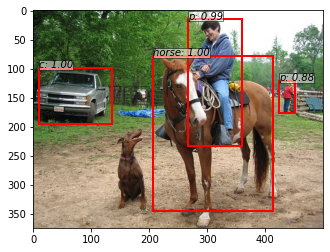

In [12]:
# in this machine the cupy isn't install correctly... 
# so it's a little slow  sudo chmod a+r /usr/local/cuda/include/cudnn.h /usr/local/cuda/lib64/libcudnn*
p1='fasterrcnn_12211511_0.701052458187_torchvision_pretrain.pth.701052458187'
p2='checkpoints/fasterrcnn_04072312_0.6659129146847483'
trainer.load(p2)
opt.caffe_pretrain=False # this model was trained from caffe-pretrained model

# eval(test_dataloader, trainer.faster_rcnn, test_num=100)
# rpn_scores.view(n, hh, ww, n_anchor, 2)

_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it

In [15]:
9*37*53*2

35298

(3, 375, 1242)
torch.Size([1, 3, 375, 1242])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


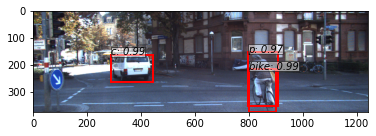

In [18]:
kfolder='/media/nagnanamus/d0690b96-7f71-44f2-96da-9f7259180ec7/SLAMData/Kitti/tracking/mot/data_tracking_image_2/training/image_02/0000'
kimgfile = '000005.png'
kimg = read_image(os.path.join(kfolder,kimgfile))
print(kimg.shape)
kimg = t.from_numpy(kimg)[None]
print(kimg.shape)

kimg2=kimg
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(kimg2,visualize=True)
vis_bbox(at.tonumpy(kimg2[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

In [8]:
trainer.faster_rcnn

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [10]:
D = iter(dataloader)

In [11]:
img, bbox_, label_, scale = D.next()
print(img.shape)
print(bbox_.shape)
print(label_.shape)
print(scale.shape)

torch.Size([1, 3, 600, 875])
torch.Size([1, 2, 4])
torch.Size([1, 2])
torch.Size([1])


In [22]:
scale

1.749271137026239

In [13]:
img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()

In [14]:
_, _, H, W = img.shape
img_size = (H, W)
print(img_size)
features = trainer.faster_rcnn.extractor(img)

(600, 875)


In [73]:
features.shape

torch.Size([1, 512, 37, 54])

In [66]:
img_size

(600, 875)

In [74]:
from model.region_proposal_network import _enumerate_shifted_anchor
anchors=_enumerate_shifted_anchor(anchor_base, 16, features.shape[2], features.shape[3])

In [77]:
37*54*9

17982

In [75]:
anchors.shape

(17982, 4)

In [71]:
anchors

array([[  -37.254833,   -82.50967 ,    53.254833,    98.50967 ],
       [  -82.50967 ,  -173.01933 ,    98.50967 ,   189.01933 ],
       [ -173.01933 ,  -354.03867 ,   189.01933 ,   370.03867 ],
       ...,
       [ 9501.49    , 13946.745   ,  9682.51    , 14037.255   ],
       [ 9410.98    , 13901.49    ,  9773.02    , 14082.51    ],
       [ 9229.961   , 13810.98    ,  9954.039   , 14173.02    ]],
      dtype=float32)

In [17]:
scale = at.scalar(scale)
rpn_locs, rpn_scores, rois, roi_indices, anchor = trainer.faster_rcnn.rpn(features, img_size, scale)

In [41]:
img_size

(600, 875)

In [45]:
scale

1.749271137026239

In [44]:
np.array(img_size)/scale

array([343.        , 500.20833333])

In [96]:
ff=range(5)
ff[slice(0, 4, 2)]

range(0, 4, 2)

In [21]:
print(rpn_locs.shape)
print(rpn_scores.shape)
print(rois.shape)
print(roi_indices.shape)
print(anchor.shape)

torch.Size([1, 17982, 4])
torch.Size([1, 17982, 2])
(1600, 4)
(1600,)
(17982, 4)


In [55]:
xx=rpn_locs.cpu().detach().numpy()[0,:,:]
xx.max(axis=0),xx.min(axis=0)

(array([0.31132758, 0.29421127, 0.69134486, 0.5706684 ], dtype=float32),
 array([-0.24422672, -0.26551542, -1.2351148 , -1.291272  ], dtype=float32))

In [58]:
anchor.max(axis=0),anchor.min(axis=0)

(array([ 538.7452,  810.7452,  946.0387, 1218.0387], dtype=float32),
 array([-354.03867 , -354.03867 ,   53.254833,   53.254833], dtype=float32))

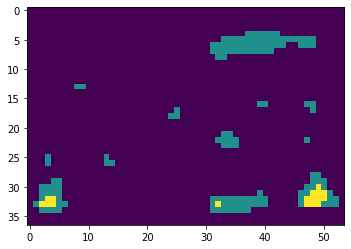

In [39]:
fimg  = features[0,1:2,:,:].cpu().detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# CHW -> HWC
fimg = fimg.transpose((1, 2, 0))
ax.imshow(fimg[:,:,0].astype(np.uint8))

In [26]:
fimg  = features[0,0:1,:,:]
fimg.shape

torch.Size([1, 37, 54])

In [82]:
features.shape

torch.Size([1, 512, 37, 54])

In [80]:
from model.region_proposal_network import _enumerate_shifted_anchor
from torch.nn import functional as F

anchor=_enumerate_shifted_anchor(anchor_base, 16, features.shape[2], features.shape[3])

n, _, hh, ww = features.shape
# anchor = _enumerate_shifted_anchor( np.array(self.anchor_base),
#     self.feat_stride, hh, ww)
# anchor is all the enumerations of sliding anchors

n_anchor = anchor.shape[0] // (hh * ww)
h = F.relu(trainer.faster_rcnn.rpn.conv1(features))

rpn_locs = trainer.faster_rcnn.rpn.loc(h)

In [88]:
anchor

array([[ -37.254833,  -82.50967 ,   53.254833,   98.50967 ],
       [ -82.50967 , -173.01933 ,   98.50967 ,  189.01933 ],
       [-173.01933 , -354.03867 ,  189.01933 ,  370.03867 ],
       ...,
       [ 493.49033 ,  810.7452  ,  674.50964 ,  901.2548  ],
       [ 402.98065 ,  765.49036 ,  765.01935 ,  946.50964 ],
       [ 221.96133 ,  674.98065 ,  946.0387  , 1037.0193  ]],
      dtype=float32)

In [83]:
rpn_locs.shape

torch.Size([1, 36, 37, 54])

In [86]:
# UNNOTE: check whether need contiguous
# A: Yes
rpn_locs2 = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
rpn_locs2.shape

torch.Size([1, 17982, 4])

In [92]:
rpn_scores1 = trainer.faster_rcnn.rpn.score(h)
rpn_scores2 = rpn_scores1.permute(0, 2, 3, 1).contiguous()
rpn_softmax_scores = F.softmax(rpn_scores2.view(n, hh, ww, n_anchor, 2), dim=4)
rpn_fg_scores1 = rpn_softmax_scores[:, :, :, :, 1].contiguous()
rpn_fg_scores2 = rpn_fg_scores1.view(n, -1)
rpn_scores3 = rpn_scores2.view(n, -1, 2)

In [93]:
print(rpn_scores1.shape)
print(rpn_scores2.shape)
print(rpn_softmax_scores.shape)
print(rpn_fg_scores1.shape)
print(rpn_fg_scores2.shape)
print(rpn_scores3.shape)

torch.Size([1, 18, 37, 54])
torch.Size([1, 37, 54, 18])
torch.Size([1, 37, 54, 9, 2])
torch.Size([1, 37, 54, 9])
torch.Size([1, 17982])
torch.Size([1, 17982, 2])


In [91]:
rpn_softmax_scores.shape

torch.Size([1, 37, 54, 9, 2])

In [68]:
# the 30th layer of features is relu of conv5_3
def vgglayersoutput(img):
    model = vgg16(not None)

    features = list(model.features)[:30]

    modulefeatures = nn.ModuleList(features).eval() 

    results = []
    x=img.clone()
    for ii,model in enumerate(modulefeatures):
        print(ii,model)
        x = model.cuda()(x)
        results.append(x)

    # freeze top4 conv
    # for layer in features[:10]:
    #     for p in layer.parameters():
    #         p.requires_grad = False

    full30vgg = nn.Sequential(*features)
    
    return features, modulefeatures,full30vgg ,results



In [44]:
modulefeatures

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [65]:
print(len(results))
for ii in range(30):
    print(ii,modulefeatures[ii],'    ->  ',results[ii].shape)


30
0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))     ->   torch.Size([1, 64, 600, 904])
1 ReLU(inplace=True)     ->   torch.Size([1, 64, 600, 904])
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))     ->   torch.Size([1, 64, 600, 904])
3 ReLU(inplace=True)     ->   torch.Size([1, 64, 600, 904])
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)     ->   torch.Size([1, 64, 300, 452])
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))     ->   torch.Size([1, 128, 300, 452])
6 ReLU(inplace=True)     ->   torch.Size([1, 128, 300, 452])
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))     ->   torch.Size([1, 128, 300, 452])
8 ReLU(inplace=True)     ->   torch.Size([1, 128, 300, 452])
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)     ->   torch.Size([1, 128, 150, 226])
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))     ->   torch.Size

In [67]:
904/56,600/37

(16.142857142857142, 16.216216216216218)

# 2. model trained with torchvision pretrained model

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


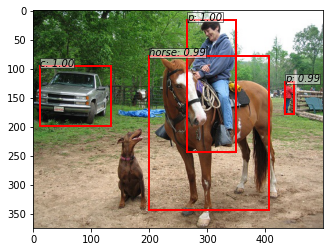

In [6]:
trainer.load('fasterrcnn_12211511_0.701052458187_torchvision_pretrain.pth.701052458187')
opt.caffe_pretrain=False # this model was trained from torchvision-pretrained model
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it

# 3. model trained with caffe pretrained model

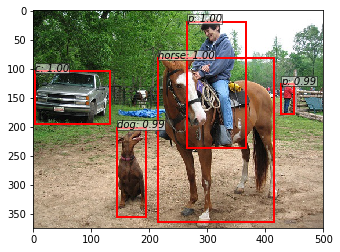

In [6]:
trainer.load('/home/cy/fasterrcnn_12222105_0.712649824453_caffe_pretrain.pth')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))